In [39]:
from picamera.array import PiYUVArray, PiRGBArray
from picamera import PiCamera
from scipy.signal import find_peaks, butter, filtfilt
from simple_pid import PID
#from ipywidgets import interact, interactive
from pwm import PWM
import ipywidgets as ipw
import time
import matplotlib.pyplot as plt
import skimage as ski
import numpy as np
import time
import threading

# Takes in a percent and a pwm, sets the speed according to the percent
def setEngineSpeed(percent, pwm):
    # If the percent is less than 0, set to 0
    if percent < 0:
        percent = 0
	# If the percent is greater than 1, set to 1
    if percent > 1:
        percent = 1
	# Calculate the speed to set the motor
    newSpeed = int(1000000 * percent + 1000000)
    #print("set engine speed ", speed)
	# Set the duty_cylce to the speed
    pwm.duty_cycle = newSpeed

# Takes in a percent and a pwm, turns to the right according to the percent
def turnRight(percent, pwm):
	# If the percent is less than 0, set to 0
    if percent < 0:
        percent = 0
	# If the percent is greater than 1, set to 1
    if percent > 1:
        percent = 1
	# Calculate the direction to set the servo
    value = int(1500000 - 500000 * percent)
    #print("turn right speed: ", value)
	# Set the duty_cylce to the value
    pwm.duty_cycle = value

# Takes in a percent and a pwm, turns to the left according to the percent
def turnLeft(percent, pwm):
	# If the percent is less than 0, set to 0
    if percent < 0:
        percent = 0
	# If the percent is greater than 1, set to 1
    if percent > 1:
        percent = 1
	# Calculate the direction to set the servo
    value = int(500000 * percent + 1500000)
    #print("turn left speed: ", value)
	# Set the duty_cylce to the value
    pwm.duty_cycle = value

def turn(percent, pwm):
    if percent < -1:
        percent = -1
    if percent > 1:
        percent = 1
    if percent < 0:
        turnRight(-1 * percent, pwm)
    else:
        turnLeft(percent, pwm)
        
#def getNewSpeed(turnPercent):
#    if turnPercent <= 0.15:
#        newSpeed = 0.20
#    elif turnPercent <=0.3:
#        newSpeed = 0.175
#    else:
#        newSpeed = 0.16
#    return newSpeed

# Set the speed to be a discounted rate of the maxSpeed
def getNewSpeed(turnPercent, maxSpeed, minSpeed):
    speed = maxSpeed - (turnPercent * maxSpeed)
    # Make sure the speed is never less than minSpeed
    if(speed < minSpeed):
        speed = minSpeed
    return speed

# Create the sliders to effect the values of maxSpeed, minSpeed, Kp, Ki, Kd. Have two buttons for stopping the program and taking pictures
maxSpeed = ipw.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.26, description='Max Speed')
display(maxSpeed)
minSpeed = ipw.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.18, description='Min Speed')
display(minSpeed)
Kp = ipw.FloatSlider(min=0.0, max=10.0, step=0.05, value=0.9, description='Kp')
display(Kp)
Ki = ipw.FloatSlider(min=0.0, max=10.0, step=0.05, value=0.7, description='Ki')
display(Ki)
Kd = ipw.FloatSlider(min=0.0, max=10.0, step=0.05, value=0.9, description='Kd')
display(Kd)
running = ipw.ToggleButton(value=True, description='STOP', disabled=False, button_style='', tooltip='Description', icon='check')
display(running)
button = ipw.ToggleButton(value=False, description='Snap photo', disabled=False,button_style='', tooltip='Description', icon='check')
display(button)

FloatSlider(value=0.25, description='Max Speed', max=1.0, step=0.01)

FloatSlider(value=0.17, description='Min Speed', max=1.0, step=0.01)

FloatSlider(value=0.6, description='Kp', max=10.0, step=0.05)

FloatSlider(value=0.5, description='Ki', max=10.0, step=0.05)

FloatSlider(value=0.6, description='Kd', max=10.0, step=0.05)

ToggleButton(value=True, description='STOP', icon='check', tooltip='Description')

ToggleButton(value=False, description='Snap photo', icon='check', tooltip='Description')

In [61]:
# Setup and export pwm0 and pwm1
pwm0 = PWM(0)
pwm1 = PWM(1)
pwm0.export()
pwm1.export()

# Set the periods to 20ms
pwm0.period = 20000000
pwm1.period = 20000000

# Set the duty_cycle of the motor to 1ms and servo to 1.5ms
setEngineSpeed(0, pwm1)
turnRight(0, pwm0)

# Enable the pwms
pwm0.enable = True
pwm1.enable = True

# Give some time to start up
time.sleep(5)

# START OF COMPUTER VISION

res = (640,480)
b, a = butter(3, 0.007)


camera = PiCamera()


# Check the link below for the combinations between mode and resolution
# https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes
camera.sensor_mode = 7
camera.resolution = res
camera.framerate = 60

# Initialize the buffer and start capturing
rawCapture = PiYUVArray(camera, size=res)
stream = camera.capture_continuous(rawCapture, format="yuv", use_video_port=True)

whiteCenterLine = 0 # Know where the center is
images = [] # Used for testing 
peaks = [] # Used for testing

# Main line following code
def func():
    global images
    turning = 'n' # Indicate which direction it is turning
    output = 0 # result of the PID
    frame_num = 6 # used for getting pictures when the button is pressed
    finLineCounter = 0 # Used to count the number of times the car passes the finish line
    pid = PID(Kp.value, Ki.value, Kd.value, setpoint=0) # PID used to follow the line
    for f in stream:
        pid = PID(Kp.value, Ki.value, Kd.value, setpoint=0) # PID used to follow the line
        #pid.tunings(Kp.value, Ki.value, Kd.value) # Tune the PID with the slider values
        pid.sample_time = 0.05
        # Get the intensity component of the image (a trick to get black and white images)
        I = f.array[:, :, 0]
        # Capture images if the button is pressed
        if (button.value):
            frame_num = 0
            button.value = False
        # Capture 3 images
        if (frame_num <=2):
            images.append(I)
            frame_num = frame_num + 1
        # Reset the buffer for the next image
        rawCapture.truncate(0)

        # Select a horizontal line in the middle of the image
        ################## Lets play around with this value to see if there is a better spot
        L = I[440, :]

        # Smooth the transitions so we can detect the peaks 
        Lf = filtfilt(b, a, L)

        # Find peaks which are higher than 0.5
        p = find_peaks(Lf, height=128)
        num_peaks = len(p[0])
        # The whiteCenterLine is the value of the peak
        if num_peaks == 1:
            whiteCenterLine = p[0][0]
        # The whiteCenterLine is the average of the two widest peaks
        elif num_peaks >= 2:
            whiteCenterLine = (p[0][0] + p[0][len(p)-1]) / 2
            images.append(I) # Add the image to the list of images for review later
            peaks.append(p) # Add the peaks to the list of peaks for review later
            # finLineCounter += 1
        elif (num_peaks == 0):
            pass # REMEMBER LAST TURN
        # Print peaks
        # print(p)
        #print("num peaks ", num_peaks)
        
        # Steer the car accordingly
        # Fully turn in the same direction if we don't see the line
        if num_peaks == 0:
            if turning == 'l':
                output = 1
            elif turning == 'r':
                output = -1
        else:
            # Check that the line is not one of the edge lines. Continue on the same path if it is
            if turning == 'l' and whiteCenterLine - 320 > 150:
                pass
            elif turning == 'r' and whiteCenterLine < 150:
                pass
            else:
                # Get how far the car is off as a percent
                if ((whiteCenterLine < 300) or (whiteCenterLine > 340)):
                    percentOff = (whiteCenterLine - 320) / 320.0
                else:
                    percentOff = 0
                output = pid(percentOff) # Get the output of the PID as a percent
                # Update turning direction
                if whiteCenterLine < 320:
                    turning = 'l'
                else:
                    turning = 'r'
        #print("output: ", output)
        # Calculate a new speed based on the percent of turning
        newSpeed = getNewSpeed(abs(output), maxSpeed.value, minSpeed.value)
        # print("speed: ", newSpeed)
        # Make sure not to set the speed faster than maxSpeed
        if newSpeed <= maxSpeed.value:
            setEngineSpeed(newSpeed, pwm1)
        else:
            setEngineSpeed(maxSpeed.value, pwm1)
        turn(output, pwm0) # Turn the car

        # Check if the loop should end
        if not running.value:
            running.value = True
            break
        if finLineCounter >= 1:
            time.sleep(0.5) # Give time to cross the finish line (May need to be changed with testing)
            break
    # Stop the motor
    setEngineSpeed(0, pwm1)
    # Reposition the servo to 0
    turnRight(0, pwm0)
    time.sleep(.1)

    #time_elapsed = time.time() - t
    #print("Elapsed {:0.2f} seconds, estimated FPS {:0.2f}".format(time_elapsed, N / time_elapsed))

    # Close the camera and the stream
    stream.close()
    rawCapture.close()
    camera.close()

    # Disable both pwms
    pwm0.enable = False
    pwm1.enable = False

# Start a thread for the main control. This allows for us to use the sliders/buttons
t = threading.Thread(target=func)
t.start()

In [45]:
stream.close()
rawCapture.close()
camera.close()

In [ ]:
for i in range(0,len(images)): 
    plt.imshow(images[i])

plt.figure(figsize=(18, 24))

for k, img in enumerate(images):
    ax = plt.subplot(4, 3, k + 1)
    ax.imshow(img)
    
plt.tight_layout()

In [62]:
len(images)

0

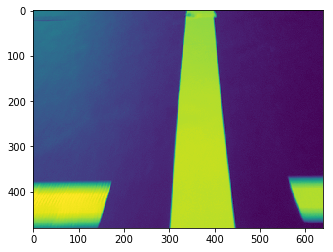

In [51]:
plt.imshow(images[0])

In [50]:
L = images[1][440, :]

# Smooth the transitions so we can detect the peaks 
Lf = filtfilt(b, a, L)

# Find peaks which are higher than 0.5
p = find_peaks(Lf, height=128)
print(p)

(array([101, 339], dtype=int32), {'peak_heights': array([168.86477212, 169.6193147 ])})
